# KNN (K-Nearest-Neighbors)

KNN is a simple concept: define some distance metric between the items in your dataset, and find the K closest items. You can then use those items to predict some property of a test item, by having them somehow "vote" on it.

As an example, let's look at the MovieLens data. We'll try to guess the rating of a movie by looking at the 10 movies that are closest to it in terms of genres and popularity.

To start, we'll load up every rating in the data set into a Pandas DataFrame:

In [56]:
import pandas as pd

r_cols = ['user_id', 'movie_id', 'rating']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, usecols=range(3))
ratings.head()


,user_id,movie_id,rating
0,0,50,5
1,0,172,5
2,0,133,1
3,196,242,3
4,186,302,3


Now, we'll group everything by movie ID, and compute the total number of ratings (each movie's popularity) and the average rating for every movie:

In [57]:
import numpy as np

movieProperties = ratings.groupby('movie_id').agg({'rating': [np.size, np.mean]})
movieProperties.head()

rating          
           size      mean
movie_id                 
1           452  3.878319
2           131  3.206107
3            90  3.033333
4           209  3.550239
5            86  3.302326

The raw number of ratings isn't very useful for computing distances between movies, so we'll create a new DataFrame that contains the normalized number of ratings. So, a value of 0 means nobody rated it, and a value of 1 will mean it's the most popular movie there is.

In [58]:
movieNumRatings = pd.DataFrame(movieProperties['rating']['size'])
movieNormalizedNumRatings = movieNumRatings.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
movieNormalizedNumRatings.head()

,size
movie_id,
1,0.773585
2,0.222985
3,0.152659
4,0.356775
5,0.145798


Now, let's get the genre information from the u.item file. The way this works is there are 19 fields, each corresponding to a specific genre - a value of '0' means it is not in that genre, and '1' means it is in that genre. A movie may have more than one genre associated with it.

While we're at it, we'll put together everything into one big Python dictionary called movieDict. Each entry will contain the movie name, list of genre values, the normalized popularity score, and the average rating for each movie:

In [59]:
movieDict = {}
with open(r'ml-100k/u.item') as f:
    temp = ''
    for line in f:
        #line.decode("ISO-8859-1")
        fields = line.rstrip('\n').split('|')
        movieID = int(fields[0])
        name = fields[1]
        genres = fields[5:25]
        genres = map(int, genres)
        movieDict[movieID] = (name, np.array(list(genres)), movieNormalizedNumRatings.loc[movieID].get('size'), movieProperties.loc[movieID].rating.get('mean'))


For example, here's the record we end up with for movie ID 1, "Toy Story":

In [60]:
print(movieDict[1])

('Toy Story (1995)', array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 0.7735849056603774, 3.8783185840707963)


Now let's define a function that computes the "distance" between two movies based on how similar their genres are, and how similar their popularity is. Just to make sure it works, we'll compute the distance between movie ID's 2 and 4:

In [61]:
from scipy import spatial

def ComputeDistance(a, b):
    genresA = a[1]
    genresB = b[1]
    genreDistance = spatial.distance.cosine(genresA, genresB)
    popularityA = a[2]
    popularityB = b[2]
    popularityDistance = abs(popularityA - popularityB)
    return genreDistance + popularityDistance
    
ComputeDistance(movieDict[2], movieDict[4])



0.8004574042309892

Remember the higher the distance, the less similar the movies are. Let's check what movies 2 and 4 actually are - and confirm they're not really all that similar:

In [62]:
print(movieDict[2])
print(movieDict[4])


('GoldenEye (1995)', array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]), 0.22298456260720412, 3.2061068702290076)
('Get Shorty (1995)', array([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 0.3567753001715266, 3.550239234449761)


Now, we just need a little code to compute the distance between some given test movie (Toy Story, in this example) and all of the movies in our data set. When the sort those by distance, and print out the K nearest neighbors:

In [74]:
import operator

def getNeighbors(movieID, K,movieDict):
    distances = []
    for movie in movieDict:
        if (movie != movieID):
            dist = ComputeDistance(movieDict[movieID], movieDict[movie])
            distances.append((movie, dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(K):
        neighbors.append(distances[x][0])
    return neighbors  #contains the movie number/movieID corresponding to the movie name

K = 4
avgRating = 0  # Just a variable to be used as a 
neighbors = getNeighbors(800, K,movieDict)
for neighbor in neighbors:
    avgRating += movieDict[neighbor][3]
    print (movieDict[neighbor][0] + " " + str(movieDict[neighbor][3]))
    
avgRating /= K

Halloween: The Curse of Michael Myers (1995) 2.2
Village of the Damned (1995) 2.6818181818181817
Believers, The (1987) 2.25
Loch Ness (1995) 2.5


While we were at it, we computed the average rating of the 10 nearest neighbors to Toy Story:

In [75]:
avgRating

2.4079545454545457

How does this compare to Toy Story's actual average rating?

In [76]:
movieDict[800]

('In the Mouth of Madness (1995)',
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]),
 0.04288164665523156,
 2.8846153846153846)

Not too bad!


## Activity

Our choice of 10 for K was arbitrary - what effect do different K values have on the results?

Our distance metric was also somewhat arbitrary - we just took the cosine distance between the genres and added it to the difference between the normalized popularity scores. Can you improve on that?

In [77]:
import numpy as np
import matplotlib.pyplot as plt

def getRelativeError(predictedRating,actualRating,movieID):
    rel_Error = np.absolute(predictedRating-movieDict[movieID][3])/movieDict[movieID][3]
    
    return rel_Error

print("Relative Error = ", getRelativeError(avgRating,movieDict[1][3],800))

Relative Error =  0.16524242424242416


How does varying the number of neighbors (K) affect the relative error and thus the accuracy of my predictions?

In [12]:
K = 10
movieID = 1
Error_Vector = []
for k in range(2,K):
    avgRating = 0
    neighbors = getNeighbors(movieID,k)
    for neighbor in neighbors:
        avgRating += movieDict[neighbor][3]
        
    avgRating /= k
    Error = getRelativeError(avgRating,movieDict[movieID][3],movieID)
    Error_Vector.append(Error)
print(Error_Vector)

[0.10148092943149704, 0.08883295430404795, 0.05449722361686309, 0.04108815819790289, 0.08551378616665863, 0.11344221233121173, 0.11327034458292749, 0.12333853530804734]


In [13]:
num_Neighbors = np.arange(2,K)
#print(len(num_Neighbors))
#print(len(Error_Vector))
assert len(Error_Vector) == len(num_Neighbors), "The ErrorVector and the num_Neighbors vectors are not the same length."

Text(0.5, 1.0, "Relative error by number of neighbors for 'Toy Story (1995)'")

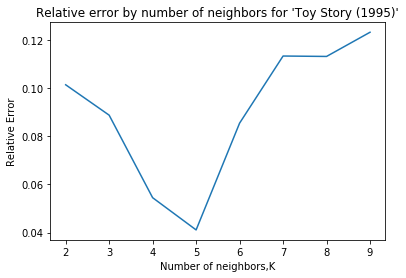

In [14]:
plt.plot(num_Neighbors,Error_Vector)
plt.xlabel("Number of neighbors,K")
plt.ylabel("Relative Error")
plt.title("Relative error by number of neighbors for '"+ str(movieDict[movieID][0])+ "'")

So we see that the number of neighbors chosen affects the relative error for a given movie. Remember this is the relative error between the predicted rating for a movie and the actual (average) rating that it was given. Since this value of K that minimises the relative error is not the same from one movie to another, we need to find the relative error that we can reliably use for any given movie in the set and we can be comfortable that it will be suitable for minimising the relative error. 

In [46]:
import time

K = 10
movieID = 1
subDict = {k:movieDict[k] for k in list(movieDict)[:10000]}
#print(subDict)
#subDict = movieDict
start_time = time.time()
#for movie in movieDict:
for movie in subDict:
    print("Calculating minimum k and expected error for '"+ str(subDict[movie][0])+"'")
    minError_Vec = []
    minK_Vec = []
    Error_Vector = []
    for k in range(2,K):
        avgRating = 0
        neighbors = getNeighbors(movieID,k,subDict)
        for neighbor in neighbors:
            avgRating += subDict[neighbor][3]
        
        avgRating /= k
        Error = getRelativeError(avgRating,subDict[movieID][3],movieID)
        Error_Vector.append(Error)
#print(Error_Vector)
        num_Neighbors = np.arange(2,K)
        minError = np.min(Error_Vector) #Gets the minimum error
        #someValue = Error_Vector.index(minError)
        #print("some value: ", someValue)
        minK = num_Neighbors[Error_Vector.index(minError)] #Gets the k corresponding to minimum error for given movie
        #print("minK:",minK)
        minError_Vec.append(minError)
        minK_Vec.append(minK)
        
print("Calculation process complete!")
print("Calculation took " + str(time.time()-start_time) + " seconds.")
optimalK = int(np.average(minK_Vec))
expectedError = np.average(minError_Vec)
print("average k = ",optimalK)
print("median k = ", np.median(minK_Vec))
print("Expected error = ", expectedError)

Calculating minimum k and expected error for 'Toy Story (1995)'
Calculating minimum k and expected error for 'GoldenEye (1995)'
Calculating minimum k and expected error for 'Four Rooms (1995)'
Calculating minimum k and expected error for 'Get Shorty (1995)'
Calculating minimum k and expected error for 'Copycat (1995)'
Calculating minimum k and expected error for 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)'
Calculating minimum k and expected error for 'Twelve Monkeys (1995)'
Calculating minimum k and expected error for 'Babe (1995)'
Calculating minimum k and expected error for 'Dead Man Walking (1995)'
Calculating minimum k and expected error for 'Richard III (1995)'
Calculating minimum k and expected error for 'Seven (Se7en) (1995)'
Calculating minimum k and expected error for 'Usual Suspects, The (1995)'
Calculating minimum k and expected error for 'Mighty Aphrodite (1995)'
Calculating minimum k and expected error for 'Postino, Il (1994)'
Calculating minimum k and expected e

Calculating minimum k and expected error for 'Haunted World of Edward D. Wood Jr., The (1995)'
Calculating minimum k and expected error for 'Cold Comfort Farm (1995)'
Calculating minimum k and expected error for 'Rock, The (1996)'
Calculating minimum k and expected error for 'Twister (1996)'
Calculating minimum k and expected error for 'Maya Lin: A Strong Clear Vision (1994)'
Calculating minimum k and expected error for 'Striptease (1996)'
Calculating minimum k and expected error for 'Independence Day (ID4) (1996)'
Calculating minimum k and expected error for 'Cable Guy, The (1996)'
Calculating minimum k and expected error for 'Frighteners, The (1996)'
Calculating minimum k and expected error for 'Lone Star (1996)'
Calculating minimum k and expected error for 'Phenomenon (1996)'
Calculating minimum k and expected error for 'Spitfire Grill, The (1996)'
Calculating minimum k and expected error for 'Godfather, The (1972)'
Calculating minimum k and expected error for 'Supercop (1992)'
Calc

Calculating minimum k and expected error for 'Star Trek III: The Search for Spock (1984)'
Calculating minimum k and expected error for 'Star Trek IV: The Voyage Home (1986)'
Calculating minimum k and expected error for 'Batman Returns (1992)'
Calculating minimum k and expected error for 'Young Guns (1988)'
Calculating minimum k and expected error for 'Under Siege (1992)'
Calculating minimum k and expected error for 'Jaws (1975)'
Calculating minimum k and expected error for 'Mars Attacks! (1996)'
Calculating minimum k and expected error for 'Citizen Ruth (1996)'
Calculating minimum k and expected error for 'Jerry Maguire (1996)'
Calculating minimum k and expected error for 'Raising Arizona (1987)'
Calculating minimum k and expected error for 'Sneakers (1992)'
Calculating minimum k and expected error for 'Beavis and Butt-head Do America (1996)'
Calculating minimum k and expected error for 'Last of the Mohicans, The (1992)'
Calculating minimum k and expected error for 'Kolya (1996)'
Calcu

Calculating minimum k and expected error for 'Jackie Brown (1997)'
Calculating minimum k and expected error for 'Wag the Dog (1997)'
Calculating minimum k and expected error for 'Desperate Measures (1998)'
Calculating minimum k and expected error for 'Hard Rain (1998)'
Calculating minimum k and expected error for 'Fallen (1998)'
Calculating minimum k and expected error for 'Prophecy II, The (1998)'
Calculating minimum k and expected error for 'Spice World (1997)'
Calculating minimum k and expected error for 'Deep Rising (1998)'
Calculating minimum k and expected error for 'Wedding Singer, The (1998)'
Calculating minimum k and expected error for 'Sphere (1998)'
Calculating minimum k and expected error for 'Client, The (1994)'
Calculating minimum k and expected error for 'One Flew Over the Cuckoo's Nest (1975)'
Calculating minimum k and expected error for 'Spawn (1997)'
Calculating minimum k and expected error for 'Assignment, The (1997)'
Calculating minimum k and expected error for 'Won

Calculating minimum k and expected error for 'Crossing Guard, The (1995)'
Calculating minimum k and expected error for 'Smoke (1995)'
Calculating minimum k and expected error for 'Like Water For Chocolate (Como agua para chocolate) (1992)'
Calculating minimum k and expected error for 'Secret of Roan Inish, The (1994)'
Calculating minimum k and expected error for 'Vanya on 42nd Street (1994)'
Calculating minimum k and expected error for 'Jungle Book, The (1994)'
Calculating minimum k and expected error for 'Red Rock West (1992)'
Calculating minimum k and expected error for 'Bronx Tale, A (1993)'
Calculating minimum k and expected error for 'Rudy (1993)'
Calculating minimum k and expected error for 'Short Cuts (1993)'
Calculating minimum k and expected error for 'Tombstone (1993)'
Calculating minimum k and expected error for 'Courage Under Fire (1996)'
Calculating minimum k and expected error for 'Dragonheart (1996)'
Calculating minimum k and expected error for 'James and the Giant Peach

Calculating minimum k and expected error for 'Boxing Helena (1993)'
Calculating minimum k and expected error for 'City Slickers II: The Legend of Curly's Gold (1994)'
Calculating minimum k and expected error for 'Cliffhanger (1993)'
Calculating minimum k and expected error for 'Coneheads (1993)'
Calculating minimum k and expected error for 'Demolition Man (1993)'
Calculating minimum k and expected error for 'Fatal Instinct (1993)'
Calculating minimum k and expected error for 'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)'
Calculating minimum k and expected error for 'Kalifornia (1993)'
Calculating minimum k and expected error for 'Piano, The (1993)'
Calculating minimum k and expected error for 'Romeo Is Bleeding (1993)'
Calculating minimum k and expected error for 'Secret Garden, The (1993)'
Calculating minimum k and expected error for 'Son in Law (1993)'
Calculating minimum k and expected error for 'Terminal Velocity (1994)'
Calculating minimum k and expected err

Calculating minimum k and expected error for 'McHale's Navy (1997)'
Calculating minimum k and expected error for 'Leave It to Beaver (1997)'
Calculating minimum k and expected error for 'Jackal, The (1997)'
Calculating minimum k and expected error for 'Seven Years in Tibet (1997)'
Calculating minimum k and expected error for 'Dark City (1998)'
Calculating minimum k and expected error for 'American President, The (1995)'
Calculating minimum k and expected error for 'Casino (1995)'
Calculating minimum k and expected error for 'Persuasion (1995)'
Calculating minimum k and expected error for 'Kicking and Screaming (1995)'
Calculating minimum k and expected error for 'City Hall (1996)'
Calculating minimum k and expected error for 'Basketball Diaries, The (1995)'
Calculating minimum k and expected error for 'Browning Version, The (1994)'
Calculating minimum k and expected error for 'Little Women (1994)'
Calculating minimum k and expected error for 'Miami Rhapsody (1995)'
Calculating minimum 

Calculating minimum k and expected error for 'Menace II Society (1993)'
Calculating minimum k and expected error for 'Poetic Justice (1993)'
Calculating minimum k and expected error for 'Program, The (1993)'
Calculating minimum k and expected error for 'Rising Sun (1993)'
Calculating minimum k and expected error for 'Shadow, The (1994)'
Calculating minimum k and expected error for 'Thirty-Two Short Films About Glenn Gould (1993)'
Calculating minimum k and expected error for 'Andre (1994)'
Calculating minimum k and expected error for 'Celluloid Closet, The (1995)'
Calculating minimum k and expected error for 'Great Day in Harlem, A (1994)'
Calculating minimum k and expected error for 'One Fine Day (1996)'
Calculating minimum k and expected error for 'Candyman: Farewell to the Flesh (1995)'
Calculating minimum k and expected error for 'Frisk (1995)'
Calculating minimum k and expected error for 'Girl 6 (1996)'
Calculating minimum k and expected error for 'Eddie (1996)'
Calculating minimum

Calculating minimum k and expected error for 'White Squall (1996)'
Calculating minimum k and expected error for 'Unforgettable (1996)'
Calculating minimum k and expected error for 'Down Periscope (1996)'
Calculating minimum k and expected error for 'Flower of My Secret, The (Flor de mi secreto, La) (1995)'
Calculating minimum k and expected error for 'Craft, The (1996)'
Calculating minimum k and expected error for 'Harriet the Spy (1996)'
Calculating minimum k and expected error for 'Chain Reaction (1996)'
Calculating minimum k and expected error for 'Island of Dr. Moreau, The (1996)'
Calculating minimum k and expected error for 'First Kid (1996)'
Calculating minimum k and expected error for 'Funeral, The (1996)'
Calculating minimum k and expected error for 'Preacher's Wife, The (1996)'
Calculating minimum k and expected error for 'Paradise Road (1997)'
Calculating minimum k and expected error for 'Brassed Off (1996)'
Calculating minimum k and expected error for 'Thousand Acres, A (199

Calculating minimum k and expected error for 'Hamlet (1996)'
Calculating minimum k and expected error for 'Two if by Sea (1996)'
Calculating minimum k and expected error for 'Forget Paris (1995)'
Calculating minimum k and expected error for 'Just Cause (1995)'
Calculating minimum k and expected error for 'Rent-a-Kid (1995)'
Calculating minimum k and expected error for 'Paper, The (1994)'
Calculating minimum k and expected error for 'Fearless (1993)'
Calculating minimum k and expected error for 'Malice (1993)'
Calculating minimum k and expected error for 'Multiplicity (1996)'
Calculating minimum k and expected error for 'She's the One (1996)'
Calculating minimum k and expected error for 'House Arrest (1996)'
Calculating minimum k and expected error for 'Ghost and Mrs. Muir, The (1947)'
Calculating minimum k and expected error for 'Associate, The (1996)'
Calculating minimum k and expected error for 'Dracula: Dead and Loving It (1995)'
Calculating minimum k and expected error for 'Now and

Calculating minimum k and expected error for 'Rendezvous in Paris (Rendez-vous de Paris, Les) (1995)'
Calculating minimum k and expected error for 'Cyclo (1995)'
Calculating minimum k and expected error for 'Relic, The (1997)'
Calculating minimum k and expected error for 'Fille seule, La (A Single Girl) (1995)'
Calculating minimum k and expected error for 'Stalker (1979)'
Calculating minimum k and expected error for 'Love! Valour! Compassion! (1997)'
Calculating minimum k and expected error for 'Palookaville (1996)'
Calculating minimum k and expected error for 'Phat Beach (1996)'
Calculating minimum k and expected error for 'Portrait of a Lady, The (1996)'
Calculating minimum k and expected error for 'Zeus and Roxanne (1997)'
Calculating minimum k and expected error for 'Big Bully (1996)'
Calculating minimum k and expected error for 'Love & Human Remains (1993)'
Calculating minimum k and expected error for 'Sum of Us, The (1994)'
Calculating minimum k and expected error for 'Little Bud

Calculating minimum k and expected error for 'Love in the Afternoon (1957)'
Calculating minimum k and expected error for 'Life with Mikey (1993)'
Calculating minimum k and expected error for 'North (1994)'
Calculating minimum k and expected error for 'Talking About Sex (1994)'
Calculating minimum k and expected error for 'Color of Night (1994)'
Calculating minimum k and expected error for 'Robocop 3 (1993)'
Calculating minimum k and expected error for 'Killer (Bulletproof Heart) (1994)'
Calculating minimum k and expected error for 'Sunset Park (1996)'
Calculating minimum k and expected error for 'Set It Off (1996)'
Calculating minimum k and expected error for 'Selena (1997)'
Calculating minimum k and expected error for 'Wild America (1997)'
Calculating minimum k and expected error for 'Gang Related (1997)'
Calculating minimum k and expected error for 'Manny & Lo (1996)'
Calculating minimum k and expected error for 'Grass Harp, The (1995)'
Calculating minimum k and expected error for 'O

Calculating minimum k and expected error for 'Second Jungle Book: Mowgli & Baloo, The (1997)'
Calculating minimum k and expected error for 'Squeeze (1996)'
Calculating minimum k and expected error for 'Roseanna's Grave (For Roseanna) (1997)'
Calculating minimum k and expected error for 'Tetsuo II: Body Hammer (1992)'
Calculating minimum k and expected error for 'Fall (1997)'
Calculating minimum k and expected error for 'Gabbeh (1996)'
Calculating minimum k and expected error for 'Mondo (1996)'
Calculating minimum k and expected error for 'Innocent Sleep, The (1995)'
Calculating minimum k and expected error for 'For Ever Mozart (1996)'
Calculating minimum k and expected error for 'Locusts, The (1997)'
Calculating minimum k and expected error for 'Stag (1997)'
Calculating minimum k and expected error for 'Swept from the Sea (1997)'
Calculating minimum k and expected error for 'Hurricane Streets (1998)'
Calculating minimum k and expected error for 'Stonewall (1995)'
Calculating minimum k 

Calculating minimum k and expected error for 'Santa with Muscles (1996)'
Calculating minimum k and expected error for 'Prisoner of the Mountains (Kavkazsky Plennik) (1996)'
Calculating minimum k and expected error for 'Naked in New York (1994)'
Calculating minimum k and expected error for 'Gold Diggers: The Secret of Bear Mountain (1995)'
Calculating minimum k and expected error for 'Bewegte Mann, Der (1994)'
Calculating minimum k and expected error for 'Killer: A Journal of Murder (1995)'
Calculating minimum k and expected error for 'Nelly & Monsieur Arnaud (1995)'
Calculating minimum k and expected error for 'Three Lives and Only One Death (1996)'
Calculating minimum k and expected error for 'Babysitter, The (1995)'
Calculating minimum k and expected error for 'Getting Even with Dad (1994)'
Calculating minimum k and expected error for 'Mad Dog Time (1996)'
Calculating minimum k and expected error for 'Children of the Revolution (1996)'
Calculating minimum k and expected error for 'Wo

Calculating minimum k and expected error for 'Leading Man, The (1996)'
Calculating minimum k and expected error for 'Tokyo Fist (1995)'
Calculating minimum k and expected error for 'Reluctant Debutante, The (1958)'
Calculating minimum k and expected error for 'Warriors of Virtue (1997)'
Calculating minimum k and expected error for 'Desert Winds (1995)'
Calculating minimum k and expected error for 'Hugo Pool (1997)'
Calculating minimum k and expected error for 'King of New York (1990)'
Calculating minimum k and expected error for 'All Things Fair (1996)'
Calculating minimum k and expected error for 'Sixth Man, The (1997)'
Calculating minimum k and expected error for 'Butterfly Kiss (1995)'
Calculating minimum k and expected error for 'Paris, France (1993)'
Calculating minimum k and expected error for 'Cérémonie, La (1995)'
Calculating minimum k and expected error for 'Hush (1998)'
Calculating minimum k and expected error for 'Nightwatch (1997)'
Calculating minimum k and expected error f

neighbors: [8, 13, 4, 7, 9, 15, 16, 12, 17]


In [36]:
medianK = np.median(minK_Vec)
print("Median K = ", medianK)

Median K =  7.0
